# Choo and Siow (2006) + Regional Quota

In [1]:
import sys
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import IPython
import multiprocessing as mp
np.set_printoptions(precision=3)
np.set_printoptions(suppress=False)
pd.set_option("display.width", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
plt.style.use("ggplot")
plt.rcParams["font.size"] = 12

In [2]:
class AggEq(object):
    def __init__(self, phi, nx_list, my_list, region_list, bar_o=None, underline_o=None, print=False):
        self.phi = phi
        self.nx_list = nx_list
        self.my_list = my_list
        self.region_list = region_list
        num_unique_regions = len(np.unique(region_list))

        if bar_o is None:
            self.bar_o = np.full(num_unique_regions, np.inf)
        else:
            self.bar_o = bar_o

        if underline_o is None:
            self.underline_o = np.full(num_unique_regions, 0)
        else:
            self.underline_o = underline_o
        
        self.x_size = len(nx_list)
        self.y_size = len(my_list)
        self.z_size = len(self.bar_o)
        self.print = print
        self.EAE_constraints_jac = self.get_EAE_constraints_jac()
        mat_size = self.x_size * self.y_size
        self.AE_constraints_jac = self.EAE_constraints_jac[0:mat_size, 0:2*mat_size]


    def get_EAE_constraints_jac(self):
        mat_size = self.x_size * self.y_size
        num_constraints = mat_size + 2 * self.z_size
        num_params = 2 * (mat_size + self.z_size)
        
        jac = np.zeros([num_constraints, num_params])
        
        # Uxy
        jac[0:mat_size, 0:mat_size] = np.diag(np.ones(mat_size))

        # Vxy
        jac[0:mat_size, mat_size:2*mat_size] = np.diag(np.ones(mat_size))

        region_mat = np.zeros([self.y_size, self.z_size])
        for y, z in enumerate(self.region_list):
            region_mat[y, z] = 1

        const_mat = np.tile(np.diag(np.ones(self.y_size)), [self.x_size, 1])
        c_z_mat = const_mat @ region_mat

        # bar_w_z
        jac[0:mat_size, 2*mat_size:2*mat_size+self.z_size] = c_z_mat
        jac[mat_size:mat_size+self.z_size, 2*mat_size:2*mat_size+self.z_size] = np.diag(np.ones(self.z_size))

        # underline_w_z
        jac[0:mat_size, 2*mat_size+self.z_size:num_params] = -1 * c_z_mat
        jac[mat_size+self.z_size:num_constraints, 2*mat_size+self.z_size:num_params] = np.diag(np.ones(self.z_size))

        return jac


    def G(self, U):
        return np.sum(self.nx_list * np.log(np.sum(np.exp(U), axis=1) + 1))


    def H(self, V):
        return np.sum(self.my_list * np.log(np.sum(np.exp(V), axis=0) + 1))


    def obj_fun_EAE(self, params):
        U, V, bar_w, underline_w = self.parse_values(params)

        # G(U), H(V)
        value = self.G(U) + self.H(V)

        # \bar{w}_z \bar{o}_z
        value += np.sum(bar_w * self.bar_o)

        # \underline{w}_z \underline{o}_z
        value -= np.sum(underline_w * self.underline_o)

        return value


    def _grad_obj_fun_EAE(self, params):
        U, V, bar_w, underline_w = self.parse_values(params)

        eU = np.exp(U)
        eV = np.exp(V)

        grad_U = self.nx_list[None].T * eU / (np.sum(eU, axis=1) + 1)[None].T
        grad_V = self.my_list * eV / (np.sum(eV, axis=0) + 1)

        grad_vec = np.concatenate([
            grad_U.ravel(), 
            grad_V.ravel(), 
            self.bar_o, 
            -1 * self.underline_o
        ])

        return grad_vec


    def obj_fun_AE_given_w(self, params):
        U, V = self.parse_values(params, include_w=False)

        # G(U), H(V)
        value = self.G(U) + self.H(V)

        return value


    def _grad_obj_fun_AE_given_w(self, params):
        U, V = self.parse_values(params, include_w=False)

        eU = np.exp(U)
        eV = np.exp(V)

        grad_U = self.nx_list[None].T * eU / (np.sum(eU, axis=1) + 1)[None].T
        grad_V = self.my_list * eV / (np.sum(eV, axis=0) + 1)

        grad_vec = np.concatenate([
            grad_U.ravel(), 
            grad_V.ravel(), 
        ])

        return grad_vec
        

    def parse_values(self, params, include_w=True):
        U = params[0:(self.x_size*self.y_size)].reshape(self.x_size, self.y_size)
        V = params[(self.x_size*self.y_size):2*(self.x_size*self.y_size)].reshape(self.x_size, self.y_size)

        if include_w:
            bar_w = params[2*(self.x_size*self.y_size):2*(self.x_size*self.y_size)+self.z_size]
            underline_w = params[2*(self.x_size*self.y_size)+self.z_size:2*(self.x_size*self.y_size)+2*self.z_size]
            return U, V, bar_w, underline_w

        return U, V


    def get_matching(self, U):
        return self.nx_list[None].T * np.exp(U) / np.array([(np.sum(np.exp(U), axis=1) + 1)]).T


    def compute_AE_given_w(self, w, init=None, tol=1e-8, maxiter=100):
        if init is None:
            init = np.zeros(2 * (self.x_size * self.y_size))

        def constraints(params):
            U, V = self.parse_values(params, include_w=False)
            val = U + V - self.phi + w[self.region_list]
            return np.ravel(val)


        def grad_constraints(params):
            return self.AE_constraints_jac
        
        
        cons = ({
            "type": "ineq", 
            "fun": constraints,
            "jac": grad_constraints,
        },)
        
        result = opt.minimize(
            self.obj_fun_AE_given_w, 
            init, 
            jac=self._grad_obj_fun_AE_given_w, 
            method="SLSQP", 
            constraints=cons,
            tol=tol, 
            options={
                "maxiter": maxiter,
                "disp": False,
            },
        )

        if self.print:
            print(result)

        U, V = self.parse_values(result.x, include_w=False)
        mu = self.get_matching(U)

        return mu, U, V, result


    def compute_EAE(self, init=None, tol=1e-8, maxiter=100):
        if init is None:
            init = np.zeros(2 * (self.x_size * self.y_size + self.z_size))

        def constraints(params):
            U, V, bar_w, underline_w = self.parse_values(params)
            val = U + V - self.phi + (bar_w - underline_w)[self.region_list]
            vec = np.concatenate([np.ravel(val), bar_w, underline_w])
            return vec

        def grad_constraints(params):
            return self.EAE_constraints_jac

        
        cons = ({
            "type": "ineq", 
            "fun": constraints,
            "jac": grad_constraints,
        },)
        
        result = opt.minimize(
            self.obj_fun_EAE, 
            init, 
            jac=self._grad_obj_fun_EAE,
            method="SLSQP", 
            constraints=cons, 
            tol=tol, 
            options={
                "maxiter": maxiter,
                "disp": False,
            },
        )

        if self.print:
            print(result)

        U, V, bar_w, underline_w = self.parse_values(result.x)
        mu = self.get_matching(U)

        return mu, U, V, bar_w, underline_w, result


    def get_regional_matches(self, mu):
        regional_matches = np.zeros(self.z_size)
        mu_y = np.sum(mu, axis=0)
        for y, z in enumerate(self.region_list):
            regional_matches[z] += mu_y[y]

        return regional_matches


    def get_government_revenue(self, mu, w):
        regional_matches = self.get_regional_matches(mu)
        gov_revenue = np.sum(regional_matches * w)
        return gov_revenue


    def get_performance(self, mu, U, V, w):
        gu = self.G(U)
        hv = self.H(V)
        regional_matches = self.get_regional_matches(mu)
        government_revenue = np.sum(regional_matches * w)
        social_welfare = gu + hv + government_revenue
        
        result = {
            "labor_welfare": gu, 
            "slot_welfare": hv, 
            "government_revenue": government_revenue, 
            "social_welfare": social_welfare, 
            "regional_matches": regional_matches, 
        }

        return result


In [3]:
class BBAE_eq(object):
    def __init__(self, w_grid, nx_list, my_list, region_list):
        self.w_grid = w_grid
        self.nx_list = nx_list
        self.my_list = my_list
        self.region_list = region_list

        # results
        self.phi_list = None
        self.results_list = None


    @staticmethod
    def split_list(li, num_splits):
        splitted_list = [[] for i in range(num_splits)]
        for i, elem in enumerate(li):
            splitted_list[i % num_splits].append(elem)

        return splitted_list


    @staticmethod
    def compute_BBAE_grids(args):
        w_grid, phi, nx_list, my_list, region_list = args
        ae = AggEq(phi, nx_list, my_list, region_list)
        num_grid = len(w_grid[0])
        results = {
            "w": [], 
            "regional_matches": [], 
            "government_revenue": [], 
            "social_welfare": [], 
        }
        need_to_compute = np.ones(num_grid, dtype=bool)
        for n, w in enumerate(zip(*w_grid)):
            if not need_to_compute[n]:   
                continue
 
            need_to_compute[n] = False
            mu, U, V, opt_result = ae.compute_AE_given_w(np.array(w))
            regional_matches = ae.get_regional_matches(mu)
            gov_revenue = np.sum(regional_matches * w)

            results["w"].append(w)
            results["regional_matches"].append(regional_matches)
            results["government_revenue"].append(gov_revenue)
            results["social_welfare"].append(opt_result.fun + gov_revenue)

            # update need_to_compute
            if gov_revenue < 0:
                conds = None
                for i, w_list in enumerate(w_grid):
                    if w[i] > 0:
                        cond = (w_list == w[i])
                    else:
                        cond = (w_list <= w[i])

                    if conds is None:
                        conds = cond
                    else:
                        conds = (conds & cond)

                need_to_compute[conds] = False

        for k in results.keys():
            results[k] = np.array(results[k])

        return results


    def compute_BBAE_for_phi_list(self, phi_list, num_threads=None):
        self.phi_list = phi_list
        if num_threads is None:
            num_threads = mp.cpu_count()

        args = []
        for phi in phi_list:
            args.append([self.w_grid, phi, self.nx_list, self.my_list, self.region_list])
        
        p = mp.get_context("fork").Pool(num_threads)
        self.results_list = p.map(self.compute_BBAE_grids, args)
        p.close()


    def get_grid_approx_BBAE(self, phi_index, bar_o, underline_o):
        phi = self.phi_list[phi_index]
        results = self.results_list[phi_index]
        ub_constraint = np.all(results["regional_matches"] <= bar_o, axis=1)
        lb_constraint = np.all(results["regional_matches"] >= underline_o, axis=1)
        gov_constraint = (results["government_revenue"] >= 0)
        valid_ind = (ub_constraint & lb_constraint & gov_constraint)
        max_ind = np.argmax(results["social_welfare"][valid_ind])
        
        return results["w"][valid_ind][max_ind]


In [4]:
class UB_AggEq(object):
    def __init__(self, bar_o_list, nx_list, my_list, region_list):
        self.bar_o_list = bar_o_list
        self.nx_list = nx_list
        self.my_list = my_list
        self.region_list = region_list

        # results
        self.phi_list = None
        self.results_list = None


    @staticmethod
    def split_list(li, num_splits):
        splitted_list = [[] for i in range(num_splits)]
        for i, elem in enumerate(li):
            splitted_list[i % num_splits].append(elem)

        return splitted_list


    @staticmethod
    def compute_AEs(args):
        bar_o_list, phi, nx_list, my_list, region_list = args
        
        ae = AggEq(phi, nx_list, my_list, region_list)
        num_list = len(bar_o_list)
        results = {
            "alg": [],
            "bar_o": [], 
            "regional_matches": [], 
        }

        for n, bar_o in enumerate(bar_o_list):
            ae.bar_o = bar_o

            # EAE
            mu, U, V, bar_w, underline_w, result = ae.compute_EAE()
            regional_matches = ae.get_regional_matches(mu)
            results["alg"].append("EAE")
            results["bar_o"].append(bar_o)
            results["regional_matches"].append(regional_matches)

            # cap reduced AE
            original_my_list = ae.my_list
            reduced_my_list = np.copy(original_my_list)
            cap_sum = np.bincount(ae.region_list, weights=ae.my_list)
            for y, z in enumerate(ae.region_list):
                if cap_sum[z] > bar_o[z]:
                    reduced_my_list[y] *= (bar_o[z] / cap_sum[z])

            ae.my_list = reduced_my_list
            mu, U, V, opt_result = ae.compute_AE_given_w(np.zeros(ae.z_size))
            regional_matches = ae.get_regional_matches(mu)
            results["alg"].append("cap_reduced_AE")
            results["bar_o"].append(bar_o)
            results["regional_matches"].append(regional_matches)

            ae.my_list = original_my_list

        for k in results.keys():
            results[k] = np.array(results[k])

        return results


    def compute_AEs_for_phi_list(self, phi_list, num_threads=None):
        self.phi_list = phi_list
        if num_threads is None:
            num_threads = mp.cpu_count()

        args = []
        for phi in phi_list:
            args.append([self.bar_o_list, phi, self.nx_list, self.my_list, self.region_list])
        
        p = mp.get_context("fork").Pool(num_threads)
        self.results_list = p.map(self.compute_AEs, args)
        p.close()


    def get_ub_approx_AEs(self, phi_index, underline_o):
        phi = self.phi_list[phi_index]
        results = self.results_list[phi_index]
        valid_ind = np.all(results["regional_matches"] >= underline_o, axis=1)

        # EAE min
        ind = valid_ind & (results["alg"] == "EAE")
        eae_bar_o = results["bar_o"][ind][-1]

        # cap reduced AE min
        ind = valid_ind & (results["alg"] == "cap_reduced_AE")
        cap_reduced_ae_bar_o = results["bar_o"][ind][-1]
        
        return eae_bar_o, cap_reduced_ae_bar_o


# equilibrium simulation



## Setup: Lower Bounds for Rural Regions

- 10 worker types, $n_x = 0.1$ for all $x$
- 3 regions（$z_1, z_2, z_3$）
- 6 type jobs（2 jobs for each）, $m_y = 0.25$ for all $y$
- $z_1$ is an urban area, $z_2, z_3$ are rural areas
- $\bar{o}_{z_1} = \bar{o}_{z_2} = \bar{o}_{z_3} = 0.5$
- $\underline{o}_{z_1} = 0.0$、$\underline{o}_{z_2} = \underline{o}_{z_3}$: parameter（$0.0 \leq \bar{o}_{z_2} = \bar{o}_{z_3} \leq 1/2$）
- $\Phi$は、
    - $\Phi_{xy} = 2.0 + \xi_{xy}$ if $y \in z_1$
    - $\Phi_{xy} = 0.5 + \xi_{xy}$ otherwise  
    - where $\xi_{xy} \sim N(0, 1)$



In [5]:
sample_size = 30
rng = np.random.default_rng(seed=2021)

x_size, y_size, z_size = 10, 6, 3
nx_list = np.repeat(0.1, x_size)
my_list = np.repeat(0.25, y_size)
region_list = np.array([0, 0, 1, 1, 2, 2])

o_z_1_list = np.linspace(0.1, 0.5, 41)
o_z_23_list = np.linspace(0.1, 0.4, 7)

In [6]:
def generate_phi_list(rng, sample_size, x_size, y_size, region_list):
    phi_list = rng.normal(size=(sample_size, x_size, y_size, ))
    phi_list += 0.5
    phi_list[:, :, np.where(region_list == 0)[0]] += 1.5

    return phi_list


def simulate(rng, sample_size, nx_list, my_list, z_size, region_list, o_z_1_list, o_z_23_list):
    x_size, y_size, z_size = len(nx_list), len(my_list), z_size

    # get phi list
    phi_list = generate_phi_list(rng, sample_size, x_size, y_size, region_list)

    # prepare for approx BBAE
    print("Preparing approx BBAE")
    w_list_size = 21
    w_grid = np.meshgrid(
        np.linspace(0, 10, w_list_size), 
        np.linspace(-2, 0, w_list_size), 
        np.linspace(-2, 0, w_list_size), 
        indexing="ij"
    )
    w_grid = [li.flatten() for li in w_grid]
    order = np.lexsort([w_grid[1], w_grid[2]])[::-1]
    w_grid = [w_list[order] for w_list in w_grid]
    
    bbae = BBAE_eq(w_grid, nx_list, my_list, region_list)
    bbae.compute_BBAE_for_phi_list(phi_list)

    # prepare for approx UB-AE
    print("Preparing approx UB-AE")
    bar_o_list = [
        np.array([o_z_1, 0.5, 0.5]) for o_z_1 in o_z_1_list
    ]
    ub_ae = UB_AggEq(bar_o_list, nx_list, my_list, region_list)
    ub_ae.compute_AEs_for_phi_list(phi_list)

    outcomes = {
        "EAE": [], 
        "BBAE": [], 
        "EAE_ub": [], 
        "cap_reduced_AE": [], 
        "no_constraint_AE": [], 
    }

    params = {
        "EAE": [], 
        "BBAE": [], 
        "EAE_ub": [], 
        "cap_reduced_AE": [], 
        "no_constraint_AE": [], 
    }

    for o_z_23 in o_z_23_list:
        print(f"o_z_23: {o_z_23}")
        bar_oz = np.array([0.5, 0.5, 0.5])
        underline_oz = np.array([0.0, o_z_23, o_z_23])
        ae = AggEq(phi_list[0], nx_list, my_list, region_list, bar_oz, underline_oz)#, print=True)

        for s, phi in enumerate(phi_list):
            if (s+1) % 10 == 0:
                print(f"Loop: {s+1} / {sample_size}")

            ae.phi = phi

            # warm start
            if s == 0:
                init_d = {k: None for k in params.keys()}
            else:
                init_d = {k: li[-1] for k, li in params.items()}

            # EAE
            eae_matching, U, V, bar_w, underline_w, opt_result = ae.compute_EAE(init_d["EAE"])
            eae_w = bar_w - underline_w
            eae_U, eae_V = U, V
            result = ae.get_performance(eae_matching, U, V, bar_w-underline_w)
            result["o_z_23"] = o_z_23
            result["s"] = s
            regional_matches = result["regional_matches"]
            result["urban_matches"] = regional_matches[0]
            result["rural_matches"] = regional_matches[1] + regional_matches[2]
            result["w_1"] = eae_w[0]
            result["w_2"] = eae_w[1]
            result["w_3"] = eae_w[2]
            result.pop("regional_matches")
            outcomes["EAE"].append(result)
            params["EAE"].append(opt_result.x)

            # No constraint AE
            w = np.zeros(z_size)
            no_constraint_ae_matching, U, V, opt_result = ae.compute_AE_given_w(w, init_d["no_constraint_AE"])
            result = ae.get_performance(no_constraint_ae_matching, U, V, w)
            result["o_z_23"] = o_z_23
            result["s"] = s
            regional_matches = result["regional_matches"]
            result["urban_matches"] = regional_matches[0]
            result["rural_matches"] = regional_matches[1] + regional_matches[2]
            result["w_1"] = w[0]
            result["w_2"] = w[1]
            result["w_3"] = w[2]
            result.pop("regional_matches")
            outcomes["no_constraint_AE"].append(result)
            params["no_constraint_AE"].append(opt_result.x)

            # approx BBAE
            w = bbae.get_grid_approx_BBAE(s, bar_oz, underline_oz)
            bbae_matching, U, V, opt_result = ae.compute_AE_given_w(w)
            result = ae.get_performance(bbae_matching, U, V, w)
            result["o_z_23"] = o_z_23
            result["s"] = s
            regional_matches = result["regional_matches"]
            result["urban_matches"] = regional_matches[0]
            result["rural_matches"] = regional_matches[1] + regional_matches[2]
            result["w_1"] = w[0]
            result["w_2"] = w[1]
            result["w_3"] = w[2]
            result.pop("regional_matches")
            outcomes["BBAE"].append(result)
            params["BBAE"].append(opt_result.x)

            # approx UB-AEs
            eae_bar_o, cap_reduced_ae_bar_o = ub_ae.get_ub_approx_AEs(s, underline_oz)

            ## EAE upper bound
            ae2 = AggEq(phi, nx_list, my_list, region_list, eae_bar_o)
            eae_ub_matching, U, V, bar_w, underline_w, opt_result = ae2.compute_EAE()
            eae_ub_w = bar_w-underline_w
            result = ae2.get_performance(eae_ub_matching, U, V, eae_ub_w)
            result["o_z_23"] = o_z_23
            result["s"] = s
            regional_matches = result["regional_matches"]
            result["urban_matches"] = regional_matches[0]
            result["rural_matches"] = regional_matches[1] + regional_matches[2]
            result["w_1"] = eae_ub_w[0]
            result["w_2"] = eae_ub_w[1]
            result["w_3"] = eae_ub_w[2]
            result.pop("regional_matches")
            outcomes["EAE_ub"].append(result)
            params["EAE_ub"].append(opt_result.x)

            ## cap reduced AE
            reduced_my_list = np.copy(my_list)
            reduced_my_list[[0, 1]] = cap_reduced_ae_bar_o[0] / 2
            ae2 = AggEq(phi, nx_list, reduced_my_list, region_list)
            w = np.zeros(z_size)
            cap_reduced_ae_matching, U, V, opt_result = ae2.compute_AE_given_w(w)
            result = ae2.get_performance(cap_reduced_ae_matching, U, V, w)
            result["o_z_23"] = o_z_23
            result["s"] = s
            regional_matches = result["regional_matches"]
            result["urban_matches"] = regional_matches[0]
            result["rural_matches"] = regional_matches[1] + regional_matches[2]
            result["w_1"] = w[0]
            result["w_2"] = w[1]
            result["w_3"] = w[2]
            result.pop("regional_matches")
            outcomes["cap_reduced_AE"].append(result)
            params["cap_reduced_AE"].append(opt_result.x)

    return outcomes


In [7]:
outcomes = simulate(rng, sample_size, nx_list, my_list, z_size, region_list, o_z_1_list, o_z_23_list)

outcome_dfs = {
    k: pd.DataFrame(v) for k, v in outcomes.items() if len(v) > 0
}

performance_dfs = {}
for k, df in outcome_dfs.items():
    performance_dfs[k] = df.groupby("o_z_23").mean().reset_index()

display(performance_dfs["EAE"])
display(performance_dfs["BBAE"])

Preparing approx BBAE
Preparing approx UB-AE
o_z_23: 0.1
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30
o_z_23: 0.15000000000000002
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30
o_z_23: 0.2
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30
o_z_23: 0.25
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30
o_z_23: 0.30000000000000004
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30
o_z_23: 0.3500000000000001
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30
o_z_23: 0.4
Loop: 10 / 30
Loop: 20 / 30
Loop: 30 / 30


,o_z_23,labor_welfare,slot_welfare,government_revenue,social_welfare,s,urban_matches,rural_matches,w_1,w_2,w_3
0,0.10,4.605107,1.722433,-5.634415e-16,6.327540,14.5,0.403712,0.585459,-7.987591e-16,-1.152383e-16,-6.905834e-16
1,0.15,4.605131,1.722409,7.278252e-16,6.327540,14.5,0.403717,0.585455,8.317493e-16,9.648395e-16,3.946485e-16
2,0.20,4.605127,1.722413,1.537756e-15,6.327540,14.5,0.403720,0.585452,1.373777e-15,1.691269e-15,1.666619e-15
3,0.25,4.605098,1.722442,-6.648835e-16,6.327540,14.5,0.403709,0.585462,-6.569566e-16,-7.519304e-16,-6.628759e-16
4,0.30,4.823684,1.687706,-1.891334e-01,6.322256,14.5,0.389607,0.601636,-3.226884e-15,-3.229054e-01,-3.075320e-01
5,0.35,6.000637,1.666689,-1.464982e+00,6.202344,14.5,0.297270,0.700000,8.765096e-16,-2.097454e+00,-2.088214e+00
6,0.40,7.225321,1.877793,-3.202930e+00,5.900184,14.5,0.199195,0.799997,1.404028e-16,-4.008755e+00,-3.998599e+00


,o_z_23,labor_welfare,slot_welfare,government_revenue,social_welfare,s,urban_matches,rural_matches,w_1,w_2,w_3
0,0.10,4.605190,1.722349,0.000000,6.327540,14.5,0.403721,0.585450,0.000000,0.000000,0.000000
1,0.15,4.605190,1.722349,0.000000,6.327540,14.5,0.403721,0.585450,0.000000,0.000000,0.000000
2,0.20,4.605190,1.722349,0.000000,6.327540,14.5,0.403721,0.585450,0.000000,0.000000,0.000000
3,0.25,4.605190,1.722349,0.000000,6.327540,14.5,0.403721,0.585450,0.000000,0.000000,0.000000
4,0.30,4.521503,1.653316,0.141398,6.316218,14.5,0.372998,0.615231,0.533333,-0.100000,-0.090000
5,0.35,4.325956,1.643021,0.209600,6.178577,14.5,0.281123,0.704406,1.866667,-0.456667,-0.436667
6,0.40,3.779177,1.853683,0.182253,5.815112,14.5,0.170820,0.804144,3.850000,-0.600000,-0.580000


In [8]:
color_pat = {
    "cap_reduced_AE": "green",
    "no_constraint_AE": "blue", 
    "EAE": "red", 
    "BBAE": "orange", 
    "EAE_ub": "purple", 
}

linewidth_pat = {
    "cap_reduced_AE": 1,
    "no_constraint_AE": 1, 
    "EAE": 2, 
    "BBAE": 1, 
    "EAE_ub": 1, 
}

marker_pat = {
    "cap_reduced_AE": "d",
    "no_constraint_AE": "s", 
    "EAE": ".", 
    "BBAE": "^", 
    "EAE_ub": "o"
}

performance_pat = {
    "social_welfare": "Social Welfare", 
    "labor_welfare": "Labor Welfare", 
    "slot_welfare": "Job Slot Welfare", 
    "government_revenue": "Government Revenue", 
    "urban_matches": "Urban Matches", 
    "rural_matches": "Rural Matches", 
}

label_pat = {
    "no_constraint_AE": "No constraint AE", 
    "EAE": "EAE", 
    "BBAE": "BBAE", 
    "cap_reduced_AE": "Cap reduced AE",
    "EAE_ub": "EAE upper bound", 
}

## For the paper

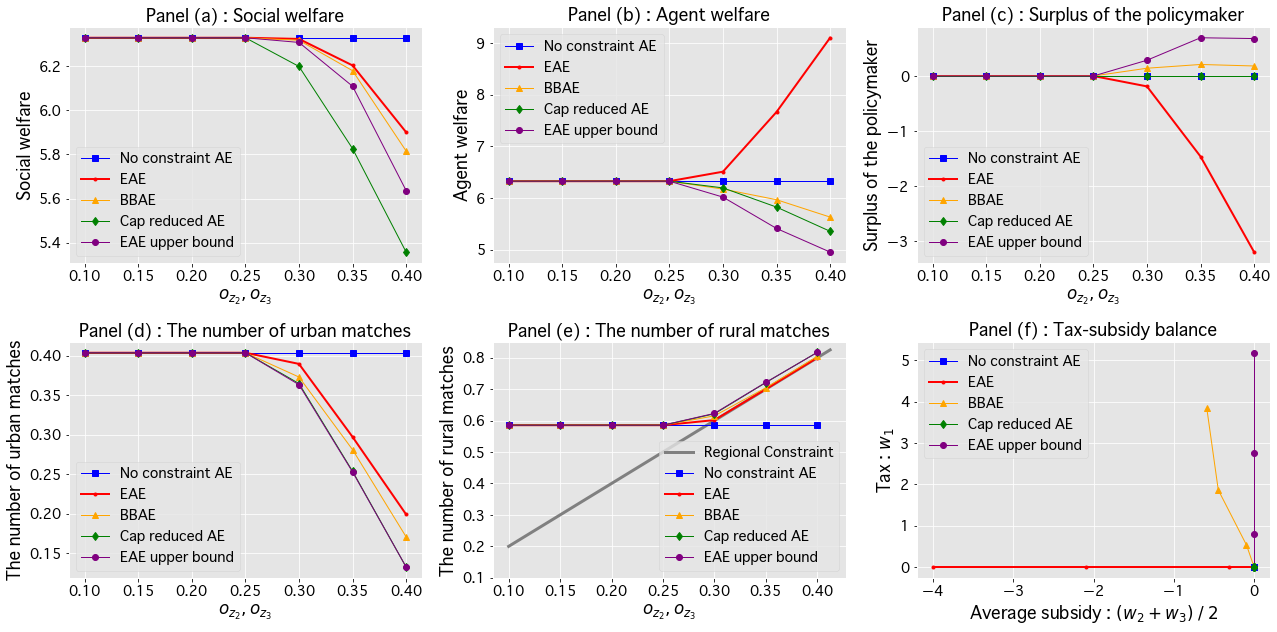

In [9]:
performance_pat = {
    "social_welfare": "Social Welfare", 
    "labor_welfare": "Labor Welfare", 
    "slot_welfare": "Job Slot Welfare", 
    "government_revenue": "Government Revenue", 
    "urban_matches": "Urban Matches", 
    "rural_matches": "Rural Matches", 
}

color = "black"
plt.rcParams["font.size"] = 14
mpl.rcParams["text.color"] = color
mpl.rcParams["axes.labelcolor"] = color
mpl.rcParams["xtick.color"] = color
mpl.rcParams["ytick.color"] = color
fs = 17
fig, axes = plt.subplots(2, 3, figsize=(18, 9), tight_layout=True)

# (a): social welfare
for key, label in label_pat.items():
    df = performance_dfs[key]
    ax = axes[0, 0]
    ax.plot(
        df["o_z_23"], 
        df["social_welfare"], 
        color=color_pat[key], 
        label=label, 
        linewidth=linewidth_pat[key], 
        marker=marker_pat[key]
    )
    ax.set_xlabel(r"$o_{z_2}, o_{z_3}$", color="black")
    ax.set_ylabel("Social welfare", color="black")
    ax.set_title("Panel (a) : Social welfare", fontsize=fs)
    ax.legend()

# (b): agent welfare
for key, label in label_pat.items():
    df = performance_dfs[key]
    ax = axes[0, 1]
    ax.plot(
        df["o_z_23"], 
        df["labor_welfare"] + df["slot_welfare"], 
        color=color_pat[key], 
        label=label, 
        linewidth=linewidth_pat[key], 
        marker=marker_pat[key]
    )
    ax.set_xlabel(r"$o_{z_2}, o_{z_3}$", color="black")
    ax.set_ylabel("Agent welfare", color="black")
    ax.set_title("Panel (b) : Agent welfare", fontsize=fs)
    ax.legend()

# (c): government revenue
for key, label in label_pat.items():
    df = performance_dfs[key]
    ax = axes[0, 2]
    ax.plot(
        df["o_z_23"], 
        df["government_revenue"], 
        color=color_pat[key], 
        label=label, 
        linewidth=linewidth_pat[key], 
        marker=marker_pat[key]
    )
    ax.set_xlabel(r"$o_{z_2}, o_{z_3}$", color="black")
    ax.set_ylabel("Surplus of the policymaker", color="black")
    ax.set_title("Panel (c) : Surplus of the policymaker", fontsize=fs)
    ax.legend()

# (d): urban matches
for key, label in label_pat.items():
    df = performance_dfs[key]
    ax = axes[1, 0]
    ax.plot(
        df["o_z_23"], 
        df["urban_matches"], 
        color=color_pat[key], 
        label=label, 
        linewidth=linewidth_pat[key], 
        marker=marker_pat[key]
    )
    ax.set_xlabel(r"$o_{z_2}, o_{z_3}$", color="black")
    ax.set_ylabel("The number of urban matches", color="black")
    ax.set_title("Panel (d) : The number of urban matches", fontsize=fs)
    ax.legend()

# (e): rural matches
ax = axes[1, 1]
vals = performance_dfs["EAE"]["o_z_23"].values
ax.plot(
    [0.1, vals[-1]+0.0125], 
    [0.2, 2*vals[-1]+0.025], 
    color="gray", 
    linewidth=3,
    label="Regional Constraint"
)
for key, label in label_pat.items():
    df = performance_dfs[key]
    ax.plot(
        df["o_z_23"], 
        df["rural_matches"], 
        color=color_pat[key], 
        label=label, 
        linewidth=linewidth_pat[key], 
        marker=marker_pat[key]
    )
    ax.set_ylim([0.1, 0.85])
    ax.set_xlabel(r"$o_{z_2}, o_{z_3}$", color="black")
    ax.set_ylabel("The number of rural matches", color="black")
    ax.set_title("Panel (e) : The number of rural matches", fontsize=fs)
    ax.legend()

# (f): w_1, w_2
for key, label in label_pat.items():
    df = performance_dfs[key]
    ax = axes[1, 2]
    if key == "no_constraint_AE":
        zorder = 5
    elif key == "cap_reduced_AE":
        zorder = 6
    else:
        zorder = 1

    ax.plot(
        (df["w_2"] + df["w_3"]) / 2, 
        df["w_1"], 
        color=color_pat[key], 
        label=label, 
        linewidth=linewidth_pat[key], 
        marker=marker_pat[key], 
        zorder=zorder,
    )
    ax.set_xlabel(r"Average subsidy : $(w_2 + w_3)$ $/$ $2$", color="black")
    ax.set_ylabel(r"Tax : $w_1$", color="black")
    ax.set_title("Panel (f) : Tax-subsidy balance", fontsize=fs)
    ax.legend()

plt.show()